In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import ast
import re

# ---------------------------------------------------------
# Parse a list-like string into a Python list
# ---------------------------------------------------------
def safe_parse_list(x):
    if pd.isna(x):
        return []
    try:
        val = ast.literal_eval(x)
        if isinstance(val, list):
            return [str(t) for t in val]
    except:
        pass
    return [t.strip() for t in str(x).split("\n") if t.strip()]


# # ---------------------------------------------------------
# # BASE model: extract steps from messy base_cot
# # ---------------------------------------------------------
# def extract_steps_from_base_cot(raw):
#     if pd.isna(raw):
#         return []

#     # base_cot is itself a string representing a list
#     try:
#         lst = ast.literal_eval(raw)
#         text = " ".join(lst) if isinstance(lst, list) else str(lst)
#     except:
#         text = str(raw)

#     # Keep only everything after "Solution:"
#     sol_split = re.split(r"Solution[:\s]+", text, flags=re.IGNORECASE)
#     if len(sol_split) > 1:
#         text = sol_split[1]

#     # Split step numbers like "1.", "2.", "3."
#     parts = re.split(r"\b\d+\.\s*", text)
#     parts = [p.strip() for p in parts if p.strip()]

#     # Deduplicate repeated steps
#     cleaned, seen = [], set()
#     for step in parts:
#         if step not in seen:
#             cleaned.append(step)
#             seen.add(step)

#     return cleaned


# ---------------------------------------------------------
# Unified normalization for base/local/meta
# ---------------------------------------------------------
def normalize_model_csv(model_path: str, gt_path: str, regime: str):
    # Load GT
    gt = pd.read_csv(gt_path)
    gt.columns = gt.columns.str.strip()
    gt["key"] = gt["key"].astype(str)
    gt.rename(columns={
        "steps": "gt_steps",
        "final_answer": "gt_final_answer",
        "num_steps": "gt_num_steps"
    }, inplace=True)
    gt["gt_steps"] = gt["gt_steps"].apply(safe_parse_list)

    # Load model
    df = pd.read_csv(model_path)
    df.columns = df.columns.str.strip()
    df["key"] = df["key"].astype(str)

    assert "question" in df.columns, f"'question' missing from {model_path}"

    # BASE
    step_col = f"{regime}_steps"
    pred_col = f"{regime}_predicted_answer"

    df["model_steps"] = df[step_col].apply(safe_parse_list)
    df["model_num_steps"] = df["model_steps"].apply(len)
    df["model_final_answer"] = df[pred_col]

    # Build normalized model
    model = df[[
        "key", "question",
        "model_steps", "model_num_steps", "model_final_answer"
    ]].copy()

    # Merge with GT
    merged = model.merge(gt, on="key", how="inner")

    # FIX THE PROBLEM HERE
    if "question_x" in merged.columns:
        merged = merged.rename(columns={"question_x": "question"})
        merged = merged.drop(columns=["question_y"], errors="ignore")

    merged["regime"] = regime

    return merged[[
        "key", "question",
        "model_steps", "model_num_steps", "model_final_answer",
        "gt_steps", "gt_num_steps", "gt_final_answer",
        "difficulty", "regime"
    ]]



In [6]:
import numpy as np

def extract_numbers(text):
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", text)
    return [float(x) for x in nums]


def is_step_valid(prev_step, cur_step):
    prev_nums = extract_numbers(prev_step)
    cur_nums = extract_numbers(cur_step)
    if not prev_nums or not cur_nums:
        return True
    for a in prev_nums:
        for b in prev_nums:
            possible = {a+b, a-b, b-a, a*b}
            if b != 0: possible.add(a/b)
            if a != 0: possible.add(b/a)
            for c in cur_nums:
                if any(abs(c - p) < 1e-6 for p in possible):
                    return True
    return False


def compute_cot_pass_1(df):
    total = len(df)
    valid_chains = 0
    for _, row in df.iterrows():
        steps = row["model_steps"]
        if len(steps) <= 1:
            valid_chains += 1
            continue
        ok = all(is_step_valid(steps[i-1], steps[i]) for i in range(1, len(steps)))
        valid_chains += int(ok)
    return valid_chains / total


def compute_trace_validity(df):
    return compute_cot_pass_1(df)


def compute_step_accuracy(df):
    correct = 0
    total = 0
    for _, row in df.iterrows():
        pred = row["model_steps"]
        gt = row["gt_steps"]
        L = min(len(pred), len(gt))
        for i in range(L):
            if extract_numbers(pred[i]) == extract_numbers(gt[i]):
                correct += 1
            total += 1
    return correct / total if total > 0 else 0


def compute_chain_length_deviance(df):
    devs = []
    for _, row in df.iterrows():
        dev = abs(len(row["model_steps"]) - len(row["gt_steps"]))
        devs.append(dev)
    return float(np.mean(devs))


def compute_locally_correct_step_ratio(df):
    ratios = []
    for _, row in df.iterrows():
        steps = row["model_steps"]
        if len(steps) <= 1:
            ratios.append(1.0)
            continue
        valid = 0
        for i in range(1, len(steps)):
            if is_step_valid(steps[i-1], steps[i]):
                valid += 1
        ratios.append(valid / (len(steps) - 1))
    return float(np.mean(ratios))


In [12]:
# # Clean base file
# import ast
# import re
# import ast
# import re

# def extract_steps_from_base_cot(raw):
#     if pd.isna(raw):
#         return []

#     # Parse raw Python list (stringified)
#     try:
#         lst = ast.literal_eval(raw)
#         text = " ".join(lst) if isinstance(lst, list) else str(lst)
#     except:
#         text = str(raw)

#     # Remove boilerplate like "Solution:" or "Answer:"
#     text = re.sub(r"(?i)solution[:\s]*", "", text)
#     text = re.sub(r"(?i)final answer[:\s]*", "", text)

#     # Split on newlines OR sentence boundaries
#     if "\n" in text:
#         parts = [p.strip() for p in text.split("\n") if p.strip()]
#     else:
#         parts = re.split(r'(?<=[.!?])\s+', text)
#         parts = [p.strip() for p in parts if p.strip()]

#     # Do NOT remove "Let x = ...", do NOT remove "=" steps
#     # Only drop pure junk
#     cleaned = [p for p in parts if len(p) > 0]

#     return cleaned


# # INPUT: the file WITHOUT good steps
# input_path = "/content/drive/MyDrive/NLP Project/Evaluation/CoT Outputs/gsm8k_base_outputs_eval_set.csv"

# # OUTPUT: file here will be overwritten
# output_path = "/content/drive/MyDrive/NLP Project/Evaluation/CoT Outputs/gsm8k_base_outputs_eval_set_with_steps.csv"

# # Load the base model eval file
# base_df = pd.read_csv(input_path)

# # Reconstruct improved base_steps
# base_df["base_steps"] = base_df["base_cot"].apply(extract_steps_from_base_cot)

# # OVERWRITE the existing _with_steps file
# base_df.to_csv(output_path, index=False)


In [7]:
# Normalize csvs
gt_path = "/content/drive/MyDrive/NLP Project/Evaluation/gsm8k_evaluation_set.csv"

datasets = {
    "base": "/content/drive/MyDrive/NLP Project/Evaluation/gsm8k_baseline_cot.csv",
    "local": "/content/drive/MyDrive/NLP Project/Evaluation/CoT Outputs/gsm8k_local_outputs.csv",
    "meta": "/content/drive/MyDrive/NLP Project/Evaluation/CoT Outputs/gsm8k_meta_outputs.csv",
    "mix": "/content/drive/MyDrive/NLP Project/Evaluation/CoT Outputs/mix_09_local_01_meta_outputs.csv"
}

normalized = {}

for regime, path in datasets.items():
    df = normalize_model_csv(path, gt_path, regime)
    normalized[regime] = df
    print(f"{regime} loaded → shape {df.shape}")

print(normalized["base"].head())
print(normalized["local"].head())
print(normalized["meta"].head())
print(normalized["mix"].head())



base loaded → shape (45, 10)
local loaded → shape (45, 10)
meta loaded → shape (45, 10)
mix loaded → shape (45, 10)
   key                                           question  \
0   65  Alex, Stan, and Adelwolfe are trying to catch ...   
1  121  Janet is collecting the results of Herbert Hoo...   
2  279  Eliza's rate per hour for the first 40 hours s...   
3  146  A tank has a capacity of 18000 gallons. Wanda ...   
4  771  A nurses’ station orders bandages in bulk pack...   

                                         model_steps  model_num_steps  \
0  [Question: Alex, Stan, and Adelwolfe are tryin...               10   
1  [Question: Janet is collecting the results of ...                7   
2  [Question: Eliza's rate per hour for the first...                5   
3  [Question: A tank has a capacity of 18000 gall...                5   
4  [Question: A nurses’ station orders bandages i...                5   

   model_final_answer                                           gt_steps  \
0 

In [8]:
# Run Evaluation
results = {}

for regime, df in normalized.items():
    results[regime] = {
        "cot_pass@1": compute_cot_pass_1(df),
        "trace_validity": compute_trace_validity(df),
        "step_accuracy": compute_step_accuracy(df),
        "chain_length_deviance": compute_chain_length_deviance(df),
        "locally_correct_step_ratio": compute_locally_correct_step_ratio(df)
    }

for r, vals in results.items():
    print(f"\n===== {r.upper()} =====")
    for metric, value in vals.items():
        print(f"{metric:28s}: {value:.4f}")



===== BASE =====
cot_pass@1                  : 0.5556
trace_validity              : 0.5556
step_accuracy               : 0.0000
chain_length_deviance       : 3.0000
locally_correct_step_ratio  : 0.7859

===== LOCAL =====
cot_pass@1                  : 0.2222
trace_validity              : 0.2222
step_accuracy               : 0.0000
chain_length_deviance       : 6.4889
locally_correct_step_ratio  : 0.6433

===== META =====
cot_pass@1                  : 0.4000
trace_validity              : 0.4000
step_accuracy               : 0.0108
chain_length_deviance       : 3.6444
locally_correct_step_ratio  : 0.7737

===== MIX =====
cot_pass@1                  : 0.6000
trace_validity              : 0.6000
step_accuracy               : 0.0000
chain_length_deviance       : 3.4889
locally_correct_step_ratio  : 0.8352


In [9]:
# ================================================================
#   GPT-4o LLM-AS-A-JUDGE PIPELINE
#   Safe API key handling + LaTeX-safe JSON sanitizer
#   Works reliably for GSM8K CoT evaluation
# ================================================================

!pip install --upgrade openai tqdm backoff

import os
import json
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
import re
import backoff


# ------------------------------------------------------------
# 1. Load your OpenAI API key from Colab Secret Manager
# ------------------------------------------------------------
# In Colab: Tools → Secrets → Add OPENAI_API_KEY
os.environ["OPENAI_API_KEY"] = "PUT YOUR KEY HERE"

client = OpenAI()


# ------------------------------------------------------------
# 2. JSON Sanitizer to fix invalid backslashes (LaTeX, \frac, \( )
# ------------------------------------------------------------
def sanitize_json_string(s):
    """
    Fix invalid JSON escape sequences such as \f, \t (latex), \(, \),
    by converting single backslashes into double, preserving JSON validity.
    """

    # Fix LaTeX-style escapes: \word -> \\word
    s = re.sub(r'\\([^\\/"bfnrtu])', r'\\\\\1', s)

    # Fix escaped parentheses: \( -> \\(
    s = s.replace(r'\(', r'\\(')
    s = s.replace(r'\)', r'\\)')

    return s


# ------------------------------------------------------------
# 3. Build judge prompt
# ------------------------------------------------------------
def build_judge_prompt(question, model_steps, model_answer, gt_steps, gt_answer):
    steps_joined = "\n".join([f"{i+1}. {s}" for i, s in enumerate(model_steps)])
    gt_joined    = "\n".join([f"{i+1}. {s}" for i, s in enumerate(gt_steps)])

    return f"""
You are an expert evaluator for GSM8K chain-of-thought reasoning.

Evaluate ONLY the model's reasoning.

Use these error categories:
- no_error
- calculator_error
- incorrect_rule_or_derivation
- false_premise_or_wrong_assumption
- missing_step_or_gap
- contradiction
- hallucinated_fact
- format_or_parsing_error
- other

Return ONLY valid JSON with EXACTLY this structure:

{{
  "error_tags": ["tag1", "tag2"],
  "is_error_free": true/false,
  "trace_coherence_score": 0.0-1.0,
  "primary_error_type": "one_tag",
  "explanation": "short explanation"
}}

---------------
QUESTION:
{question}

MODEL CHAIN OF THOUGHT:
{steps_joined}

MODEL FINAL ANSWER:
{model_answer}

GROUND TRUTH CHAIN OF THOUGHT:
{gt_joined}

GROUND TRUTH FINAL ANSWER:
{gt_answer}
---------------

Return ONLY JSON. Nothing else.
"""


# ------------------------------------------------------------
# 4. Robust GPT-4o API call with retry (for rate limits, network)
# ------------------------------------------------------------
@backoff.on_exception(
    backoff.expo,
    Exception,
    max_tries=5
)
def gpt_call(prompt):
    return client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
        max_tokens=800,
        timeout=60
    )


# ------------------------------------------------------------
# 5. Judge function with JSON sanitization
# ------------------------------------------------------------
def llm_judge_gpt4(question, model_steps, model_answer, gt_steps, gt_answer):

    prompt = build_judge_prompt(question, model_steps, model_answer, gt_steps, gt_answer)
    response = gpt_call(prompt)
    text = response.choices[0].message.content

    # Extract JSON substring
    try:
        json_str = text[text.index("{") : text.rindex("}") + 1]
        json_str = sanitize_json_string(json_str)   # ⭐ FIXES \frac, \( etc.
        result = json.loads(json_str)
        return result

    except Exception:
        print("\nRAW MODEL OUTPUT (JSON parse failure):\n")
        print(text)
        raise


# ------------------------------------------------------------
# 6. Evaluate one regime (base / local / meta)
# ------------------------------------------------------------
def evaluate_regime(df, regime_name):
    print(f"\n===== Evaluating {regime_name.upper()} =====")
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        out = llm_judge_gpt4(
            question=row["question"],
            model_steps=row["model_steps"],
            model_answer=row["model_final_answer"],
            gt_steps=row["gt_steps"],
            gt_answer=row["gt_final_answer"]
        )
        out["regime"] = regime_name
        results.append(out)

    out_df = pd.DataFrame(results)
    print("\nSummary:")
    print("Error-Free %:", out_df["is_error_free"].mean())
    print("Mean Coherence Score:", out_df["trace_coherence_score"].mean())

    return out_df


# ------------------------------------------------------------
# 7. Run on all datasets
# ------------------------------------------------------------
judge_base  = evaluate_regime(normalized["base"],  "base")
judge_local = evaluate_regime(normalized["local"], "local")
judge_meta  = evaluate_regime(normalized["meta"],  "meta")
judge_mix = evaluate_regime(normalized["mix"], "mix")

all_judge = pd.concat([judge_base, judge_local, judge_meta, judge_mix], ignore_index=True)

output_path = "/content/drive/MyDrive/NLP Project/Evaluation/gpt4_judge_results.csv"

all_judge.to_csv(output_path, index=False)

print("\nSaved judge results to:", output_path)


<>:32: SyntaxWarning: invalid escape sequence '\('
<>:32: SyntaxWarning: invalid escape sequence '\('
/tmp/ipython-input-477872856.py:32: SyntaxWarning: invalid escape sequence '\('
  Fix invalid JSON escape sequences such as \f, \t (latex), \(, \),



===== Evaluating BASE =====


100%|██████████| 45/45 [00:54<00:00,  1.22s/it]



Summary:
Error-Free %: 0.022222222222222223
Mean Coherence Score: 0.37555555555555553

===== Evaluating LOCAL =====


100%|██████████| 45/45 [00:45<00:00,  1.02s/it]



Summary:
Error-Free %: 0.06666666666666667
Mean Coherence Score: 0.5133333333333333

===== Evaluating META =====


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]



Summary:
Error-Free %: 0.044444444444444446
Mean Coherence Score: 0.3644444444444444

===== Evaluating MIX =====


100%|██████████| 45/45 [01:07<00:00,  1.50s/it]



Summary:
Error-Free %: 0.1111111111111111
Mean Coherence Score: 0.42000000000000004

Saved judge results to: /content/drive/MyDrive/NLP Project/Evaluation/gpt4_judge_results.csv


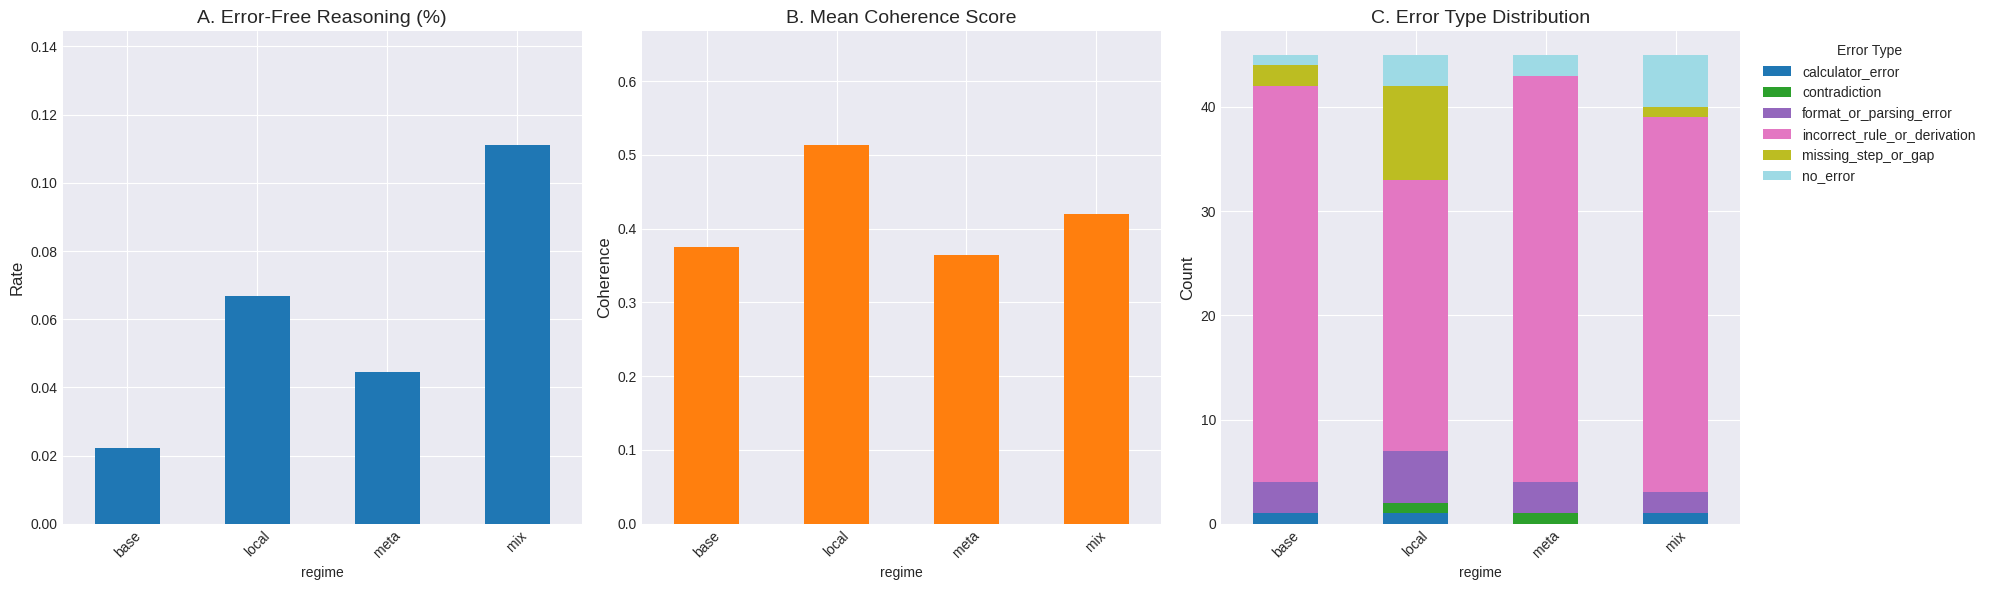

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Use your real data:
all_judge = pd.read_csv("/content/drive/MyDrive/NLP Project/Evaluation/gpt4_judge_results.csv")

plt.style.use("seaborn-v0_8-darkgrid")

# Prepare grouped metrics
error_free = all_judge.groupby("regime")["is_error_free"].mean()
coherence  = all_judge.groupby("regime")["trace_coherence_score"].mean()
error_type = (
    all_judge.groupby(["regime", "primary_error_type"])
    .size()
    .unstack(fill_value=0)
)

# --------------------------------------------
#  Unified Multi-Panel Figure (Poster-Ready)
# --------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
#fig.suptitle("LLM-as-a-Judge Evaluation Results using GPT-4o", fontsize=20, y=1.02)

# Panel A — Error-Free Rates
error_free.plot(kind="bar", ax=axes[0], color="#1f77b4")
axes[0].set_title("A. Error-Free Reasoning (%)", fontsize=14)
axes[0].set_ylabel("Rate", fontsize=12)
axes[0].set_ylim(0, max(error_free)*1.3)
axes[0].tick_params(axis="x", rotation=45)

# Panel B — Mean Coherence
coherence.plot(kind="bar", ax=axes[1], color="#ff7f0e")
axes[1].set_title("B. Mean Coherence Score", fontsize=14)
axes[1].set_ylabel("Coherence", fontsize=12)
axes[1].set_ylim(0, max(coherence)*1.3)
axes[1].tick_params(axis="x", rotation=45)

# Panel C — Error Type Distribution (Stacked)
error_type.plot(kind="bar", stacked=True, ax=axes[2], colormap="tab20")
axes[2].set_title("C. Error Type Distribution", fontsize=14)
axes[2].set_ylabel("Count", fontsize=12)
axes[2].tick_params(axis="x", rotation=45)
axes[2].legend(title="Error Type", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [19]:
print(normalized["base"].iloc[0]["model_steps"])




['You are a careful math tutor.', 'Solve the problem step by step and keep your reasoning concise.', 'End with a line exactly like: <number>', 'Problem: Alex, Stan, and Adelwolfe are trying to catch them all, Pokemon that is.  Together they have caught 339 Pokemon.  Alex has caught 5 more than Stan, and Stan has caught 13 less than 4 times as many as Adelwolfe has caught. How many Pokemon has Stan caught?', '1.  Let A = 5.  Let S = 4 * A + 13 = 4 * 5 + 13 = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 5.  Let S = 23.  Let A = 

no_error: Fully correct and consistent reasoning.\
calculator_error: Slip in basic arithmetic.\
incorrect_rule_or_derivation: Wrong algebra or invalid step.\
false_premise: Invented assumption or incorrect interpretation.\
missing_step: Missing intermediate logic or skipped derivation.\
contradiction: Conflicting values or statements.\
hallucination: Introducing nonexistent facts or operations.\
format_error: Unparseable or malformed steps.\
other: Any error not captured by above categories.\

In [10]:
print(normalized['base'])

     key                                           question  \
0     65  Alex, Stan, and Adelwolfe are trying to catch ...   
1    121  Janet is collecting the results of Herbert Hoo...   
2    279  Eliza's rate per hour for the first 40 hours s...   
3    146  A tank has a capacity of 18000 gallons. Wanda ...   
4    771  A nurses’ station orders bandages in bulk pack...   
5   1205  Bahati, Azibo, and Dinar each contributed to t...   
6    603  James wants to hang crepe-paper streamers from...   
7    372  Although Soledad works in a windowless office,...   
8    564  Ralph has a record store where people can trad...   
9    281  A wooden bridge can carry no more than 5000 po...   
10   431  To have the car for the weekend, Wilson's repo...   
11   773  Jo has been making face masks. She can make 4 ...   
12    20  Kelly is grocery shopping at a supermarket and...   
13   405  Jaime is a computer programmer for a company t...   
14  1229  Gabriel and Luri each own a portable media pl